<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:14:04] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


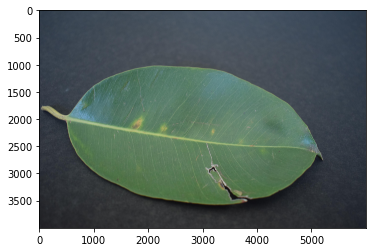

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

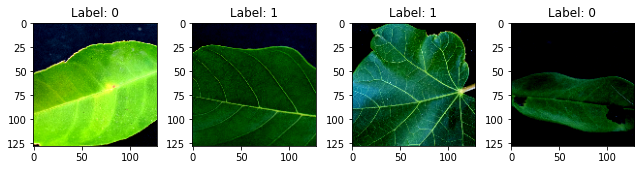

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:14:09] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:14:11] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2465065093222285 samples/sec                   batch loss = 0.3023921847343445 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2660676725097815 samples/sec                   batch loss = 0.8172829747200012 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2585966928822798 samples/sec                   batch loss = 0.4416901171207428 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2345719857242725 samples/sec                   batch loss = 1.1406214237213135 | accuracy = 0.6125


Epoch[1] Batch[25] Speed: 1.260014553405056 samples/sec                   batch loss = 0.43738219141960144 | accuracy = 0.63


Epoch[1] Batch[30] Speed: 1.2640102777019764 samples/sec                   batch loss = 2.157128095626831 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.2277136113319647 samples/sec                   batch loss = 0.7882973551750183 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2668504533894969 samples/sec                   batch loss = 0.5062557458877563 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.2650342754501456 samples/sec                   batch loss = 0.20637640357017517 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.2650751973727916 samples/sec                   batch loss = 0.9094151854515076 | accuracy = 0.625


Epoch[1] Batch[55] Speed: 1.2640178010471994 samples/sec                   batch loss = 0.5170199275016785 | accuracy = 0.6363636363636364


Epoch[1] Batch[60] Speed: 1.2663707084383722 samples/sec                   batch loss = 0.5149944424629211 | accuracy = 0.6291666666666667


Epoch[1] Batch[65] Speed: 1.2670358697866095 samples/sec                   batch loss = 0.7082503437995911 | accuracy = 0.6384615384615384


Epoch[1] Batch[70] Speed: 1.2687226055447236 samples/sec                   batch loss = 0.7180920839309692 | accuracy = 0.6321428571428571


Epoch[1] Batch[75] Speed: 1.2662564914904841 samples/sec                   batch loss = 0.5329970121383667 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.2650069956391488 samples/sec                   batch loss = 0.5395126342773438 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.2652856675380084 samples/sec                   batch loss = 0.4217775762081146 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.2686408673438563 samples/sec                   batch loss = 0.8105282187461853 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.2714512287985567 samples/sec                   batch loss = 0.6560829281806946 | accuracy = 0.6421052631578947


Epoch[1] Batch[100] Speed: 1.2626992515195736 samples/sec                   batch loss = 0.45061391592025757 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.2619742719125768 samples/sec                   batch loss = 0.48200124502182007 | accuracy = 0.65


Epoch[1] Batch[110] Speed: 1.2607308402489659 samples/sec                   batch loss = 0.6163511872291565 | accuracy = 0.65


Epoch[1] Batch[115] Speed: 1.2628278458949855 samples/sec                   batch loss = 0.6197371482849121 | accuracy = 0.65


Epoch[1] Batch[120] Speed: 1.2667524093808389 samples/sec                   batch loss = 0.4310340881347656 | accuracy = 0.65625


Epoch[1] Batch[125] Speed: 1.2673840787576487 samples/sec                   batch loss = 2.3494739532470703 | accuracy = 0.652


Epoch[1] Batch[130] Speed: 1.2664833207116915 samples/sec                   batch loss = 1.1537518501281738 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.2690758701987424 samples/sec                   batch loss = 0.22158360481262207 | accuracy = 0.6537037037037037


Epoch[1] Batch[140] Speed: 1.2638533554245557 samples/sec                   batch loss = 0.5055068731307983 | accuracy = 0.6553571428571429


Epoch[1] Batch[145] Speed: 1.2693874552358853 samples/sec                   batch loss = 0.39107564091682434 | accuracy = 0.6586206896551724


Epoch[1] Batch[150] Speed: 1.2659408055601982 samples/sec                   batch loss = 0.538328230381012 | accuracy = 0.6566666666666666


Epoch[1] Batch[155] Speed: 1.2655115762985716 samples/sec                   batch loss = 0.9634883999824524 | accuracy = 0.6532258064516129


Epoch[1] Batch[160] Speed: 1.2687136829050651 samples/sec                   batch loss = 0.8006103038787842 | accuracy = 0.65625


Epoch[1] Batch[165] Speed: 1.271025766028056 samples/sec                   batch loss = 0.31185582280158997 | accuracy = 0.6590909090909091


Epoch[1] Batch[170] Speed: 1.271264806952775 samples/sec                   batch loss = 0.20583467185497284 | accuracy = 0.6588235294117647


Epoch[1] Batch[175] Speed: 1.2688651929203119 samples/sec                   batch loss = 0.5475435256958008 | accuracy = 0.6542857142857142


Epoch[1] Batch[180] Speed: 1.2683507434161825 samples/sec                   batch loss = 0.8876222372055054 | accuracy = 0.6541666666666667


Epoch[1] Batch[185] Speed: 1.2653028440778864 samples/sec                   batch loss = 0.34747451543807983 | accuracy = 0.6554054054054054


Epoch[1] Batch[190] Speed: 1.2727305830103692 samples/sec                   batch loss = 0.8062375783920288 | accuracy = 0.656578947368421


Epoch[1] Batch[195] Speed: 1.266674080733144 samples/sec                   batch loss = 0.7493185997009277 | accuracy = 0.6576923076923077


Epoch[1] Batch[200] Speed: 1.2644272441410487 samples/sec                   batch loss = 1.0079368352890015 | accuracy = 0.65625


Epoch[1] Batch[205] Speed: 1.2670110870538764 samples/sec                   batch loss = 0.4932813346385956 | accuracy = 0.6621951219512195


Epoch[1] Batch[210] Speed: 1.2663193799470036 samples/sec                   batch loss = 0.4698290228843689 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.2662000118942929 samples/sec                   batch loss = 0.367878794670105 | accuracy = 0.663953488372093


Epoch[1] Batch[220] Speed: 1.269810187883622 samples/sec                   batch loss = 1.248948574066162 | accuracy = 0.6670454545454545


Epoch[1] Batch[225] Speed: 1.2711047301200666 samples/sec                   batch loss = 0.3880529999732971 | accuracy = 0.67


Epoch[1] Batch[230] Speed: 1.2736225589151975 samples/sec                   batch loss = 0.4206479787826538 | accuracy = 0.6695652173913044


Epoch[1] Batch[235] Speed: 1.2680711032787042 samples/sec                   batch loss = 0.3994046449661255 | accuracy = 0.6702127659574468


Epoch[1] Batch[240] Speed: 1.2617860634940141 samples/sec                   batch loss = 0.7004690766334534 | accuracy = 0.665625


Epoch[1] Batch[245] Speed: 1.2671648704758465 samples/sec                   batch loss = 0.25690263509750366 | accuracy = 0.6693877551020408


Epoch[1] Batch[250] Speed: 1.2637270270272305 samples/sec                   batch loss = 0.30868950486183167 | accuracy = 0.669


Epoch[1] Batch[255] Speed: 1.2675373781587165 samples/sec                   batch loss = 0.34056398272514343 | accuracy = 0.6705882352941176


Epoch[1] Batch[260] Speed: 1.2630769353542104 samples/sec                   batch loss = 0.5529340505599976 | accuracy = 0.6721153846153847


Epoch[1] Batch[265] Speed: 1.2656220308487343 samples/sec                   batch loss = 0.7741809487342834 | accuracy = 0.6726415094339623


Epoch[1] Batch[270] Speed: 1.26214487539442 samples/sec                   batch loss = 0.41164422035217285 | accuracy = 0.6731481481481482


Epoch[1] Batch[275] Speed: 1.2636277527253095 samples/sec                   batch loss = 0.5828965306282043 | accuracy = 0.6754545454545454


Epoch[1] Batch[280] Speed: 1.268813086280599 samples/sec                   batch loss = 0.7176546454429626 | accuracy = 0.6776785714285715


Epoch[1] Batch[285] Speed: 1.2708747023212992 samples/sec                   batch loss = 0.3505253195762634 | accuracy = 0.6807017543859649


Epoch[1] Batch[290] Speed: 1.2646278708725813 samples/sec                   batch loss = 1.1310755014419556 | accuracy = 0.6775862068965517


Epoch[1] Batch[295] Speed: 1.261897766912725 samples/sec                   batch loss = 0.29938817024230957 | accuracy = 0.6771186440677966


Epoch[1] Batch[300] Speed: 1.261117111222828 samples/sec                   batch loss = 0.37851065397262573 | accuracy = 0.6775


Epoch[1] Batch[305] Speed: 1.2653598162736588 samples/sec                   batch loss = 0.3782201111316681 | accuracy = 0.6786885245901639


Epoch[1] Batch[310] Speed: 1.2660007967016942 samples/sec                   batch loss = 0.6510365009307861 | accuracy = 0.6766129032258065


Epoch[1] Batch[315] Speed: 1.2630367131144313 samples/sec                   batch loss = 1.2794468402862549 | accuracy = 0.6753968253968254


Epoch[1] Batch[320] Speed: 1.2669053646638613 samples/sec                   batch loss = 1.25076162815094 | accuracy = 0.675


Epoch[1] Batch[325] Speed: 1.2667871295722237 samples/sec                   batch loss = 0.6979761719703674 | accuracy = 0.6753846153846154


Epoch[1] Batch[330] Speed: 1.2699753222075227 samples/sec                   batch loss = 0.29626667499542236 | accuracy = 0.6772727272727272


Epoch[1] Batch[335] Speed: 1.2649752342647123 samples/sec                   batch loss = 0.7986554503440857 | accuracy = 0.6753731343283582


Epoch[1] Batch[340] Speed: 1.2735110902282036 samples/sec                   batch loss = 0.4856117367744446 | accuracy = 0.6772058823529412


Epoch[1] Batch[345] Speed: 1.2696382746702972 samples/sec                   batch loss = 0.702156662940979 | accuracy = 0.6746376811594202


Epoch[1] Batch[350] Speed: 1.269153632106473 samples/sec                   batch loss = 0.5637548565864563 | accuracy = 0.675


Epoch[1] Batch[355] Speed: 1.2736664556695838 samples/sec                   batch loss = 0.33234739303588867 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.2683796060007184 samples/sec                   batch loss = 0.38748812675476074 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.2692276587752946 samples/sec                   batch loss = 0.5149252414703369 | accuracy = 0.6746575342465754


Epoch[1] Batch[370] Speed: 1.2621942517297677 samples/sec                   batch loss = 0.7106718420982361 | accuracy = 0.6722972972972973


Epoch[1] Batch[375] Speed: 1.2678537651492292 samples/sec                   batch loss = 0.389966756105423 | accuracy = 0.6733333333333333


Epoch[1] Batch[380] Speed: 1.2664276812450794 samples/sec                   batch loss = 0.6674239635467529 | accuracy = 0.6723684210526316


Epoch[1] Batch[385] Speed: 1.262691838895029 samples/sec                   batch loss = 0.4188755452632904 | accuracy = 0.6746753246753247


Epoch[1] Batch[390] Speed: 1.2614873990858788 samples/sec                   batch loss = 0.29155823588371277 | accuracy = 0.6775641025641026


Epoch[1] Batch[395] Speed: 1.2675345052493552 samples/sec                   batch loss = 0.16243579983711243 | accuracy = 0.6791139240506329


Epoch[1] Batch[400] Speed: 1.2702204114834261 samples/sec                   batch loss = 0.272141695022583 | accuracy = 0.680625


Epoch[1] Batch[405] Speed: 1.2628969536174188 samples/sec                   batch loss = 0.41081932187080383 | accuracy = 0.6808641975308642


Epoch[1] Batch[410] Speed: 1.2683266762852727 samples/sec                   batch loss = 0.5130394101142883 | accuracy = 0.6823170731707318


Epoch[1] Batch[415] Speed: 1.2622612008157457 samples/sec                   batch loss = 0.8818680644035339 | accuracy = 0.6837349397590361


Epoch[1] Batch[420] Speed: 1.2625621320521996 samples/sec                   batch loss = 0.9073760509490967 | accuracy = 0.6839285714285714


Epoch[1] Batch[425] Speed: 1.2669580801388056 samples/sec                   batch loss = 0.3365998864173889 | accuracy = 0.6864705882352942


Epoch[1] Batch[430] Speed: 1.26920519062457 samples/sec                   batch loss = 0.6930518746376038 | accuracy = 0.6872093023255814


Epoch[1] Batch[435] Speed: 1.2715300530296312 samples/sec                   batch loss = 0.7232334613800049 | accuracy = 0.6867816091954023


Epoch[1] Batch[440] Speed: 1.2670095561060435 samples/sec                   batch loss = 0.8505832552909851 | accuracy = 0.6857954545454545


Epoch[1] Batch[445] Speed: 1.2728553380636582 samples/sec                   batch loss = 0.5437032580375671 | accuracy = 0.6870786516853933


Epoch[1] Batch[450] Speed: 1.2672919828970284 samples/sec                   batch loss = 0.09186407923698425 | accuracy = 0.6872222222222222


Epoch[1] Batch[455] Speed: 1.2669208631322468 samples/sec                   batch loss = 0.6366159915924072 | accuracy = 0.6873626373626374


Epoch[1] Batch[460] Speed: 1.2661261468625538 samples/sec                   batch loss = 0.42673158645629883 | accuracy = 0.6869565217391305


Epoch[1] Batch[465] Speed: 1.2653376757154078 samples/sec                   batch loss = 0.49342527985572815 | accuracy = 0.6876344086021505


Epoch[1] Batch[470] Speed: 1.2684209364405075 samples/sec                   batch loss = 0.42383086681365967 | accuracy = 0.6867021276595745


Epoch[1] Batch[475] Speed: 1.2660217185165197 samples/sec                   batch loss = 0.37675243616104126 | accuracy = 0.6878947368421052


Epoch[1] Batch[480] Speed: 1.2696501888974807 samples/sec                   batch loss = 0.2998819053173065 | accuracy = 0.6885416666666667


Epoch[1] Batch[485] Speed: 1.2692221856909354 samples/sec                   batch loss = 0.6511796116828918 | accuracy = 0.6896907216494845


Epoch[1] Batch[490] Speed: 1.27157775703605 samples/sec                   batch loss = 0.2887699007987976 | accuracy = 0.6908163265306122


Epoch[1] Batch[495] Speed: 1.2751842027256075 samples/sec                   batch loss = 0.22439803183078766 | accuracy = 0.6924242424242424


Epoch[1] Batch[500] Speed: 1.2672199047267139 samples/sec                   batch loss = 0.43641653656959534 | accuracy = 0.692


Epoch[1] Batch[505] Speed: 1.2635656071464911 samples/sec                   batch loss = 0.3523692190647125 | accuracy = 0.6935643564356435


Epoch[1] Batch[510] Speed: 1.2698173959943102 samples/sec                   batch loss = 0.6755055785179138 | accuracy = 0.6946078431372549


Epoch[1] Batch[515] Speed: 1.2645290268497729 samples/sec                   batch loss = 0.2936842739582062 | accuracy = 0.695631067961165


Epoch[1] Batch[520] Speed: 1.27117060523444 samples/sec                   batch loss = 0.7202634811401367 | accuracy = 0.6956730769230769


Epoch[1] Batch[525] Speed: 1.2667698170625816 samples/sec                   batch loss = 0.6966776251792908 | accuracy = 0.6966666666666667


Epoch[1] Batch[530] Speed: 1.2618141535714176 samples/sec                   batch loss = 0.30609261989593506 | accuracy = 0.6966981132075472


Epoch[1] Batch[535] Speed: 1.2664437416201182 samples/sec                   batch loss = 0.27568015456199646 | accuracy = 0.6957943925233645


Epoch[1] Batch[540] Speed: 1.2671421881844684 samples/sec                   batch loss = 0.7705591320991516 | accuracy = 0.6962962962962963


Epoch[1] Batch[545] Speed: 1.2759373497501774 samples/sec                   batch loss = 0.35880428552627563 | accuracy = 0.6963302752293578


Epoch[1] Batch[550] Speed: 1.2695042550205005 samples/sec                   batch loss = 0.5146759748458862 | accuracy = 0.6968181818181818


Epoch[1] Batch[555] Speed: 1.2648405761241854 samples/sec                   batch loss = 0.41811519861221313 | accuracy = 0.6963963963963964


Epoch[1] Batch[560] Speed: 1.2687636704935288 samples/sec                   batch loss = 0.630786120891571 | accuracy = 0.696875


Epoch[1] Batch[565] Speed: 1.270295332101442 samples/sec                   batch loss = 0.5752682089805603 | accuracy = 0.6964601769911505


Epoch[1] Batch[570] Speed: 1.260974459075829 samples/sec                   batch loss = 0.17729726433753967 | accuracy = 0.6982456140350877


Epoch[1] Batch[575] Speed: 1.2660228649373155 samples/sec                   batch loss = 0.5947220921516418 | accuracy = 0.6982608695652174


Epoch[1] Batch[580] Speed: 1.26596860329626 samples/sec                   batch loss = 0.1851472705602646 | accuracy = 0.6987068965517241


Epoch[1] Batch[585] Speed: 1.2690362248938936 samples/sec                   batch loss = 0.1749143749475479 | accuracy = 0.6991452991452991


Epoch[1] Batch[590] Speed: 1.2659321130479346 samples/sec                   batch loss = 0.6024004817008972 | accuracy = 0.6995762711864407


Epoch[1] Batch[595] Speed: 1.2663834217244045 samples/sec                   batch loss = 0.7562316060066223 | accuracy = 0.6991596638655462


Epoch[1] Batch[600] Speed: 1.2684384859105493 samples/sec                   batch loss = 0.4698919653892517 | accuracy = 0.6991666666666667


Epoch[1] Batch[605] Speed: 1.2701177105440746 samples/sec                   batch loss = 0.44163116812705994 | accuracy = 0.7004132231404959


Epoch[1] Batch[610] Speed: 1.265211145841063 samples/sec                   batch loss = 0.5473586320877075 | accuracy = 0.6991803278688524


Epoch[1] Batch[615] Speed: 1.2705833634560029 samples/sec                   batch loss = 0.815438985824585 | accuracy = 0.6995934959349593


Epoch[1] Batch[620] Speed: 1.2692310194645195 samples/sec                   batch loss = 0.2810192108154297 | accuracy = 0.7008064516129032


Epoch[1] Batch[625] Speed: 1.2684664893492754 samples/sec                   batch loss = 0.2569505572319031 | accuracy = 0.7024


Epoch[1] Batch[630] Speed: 1.2674100250185043 samples/sec                   batch loss = 0.649476170539856 | accuracy = 0.7027777777777777


Epoch[1] Batch[635] Speed: 1.2667003804808794 samples/sec                   batch loss = 0.3619336187839508 | accuracy = 0.7023622047244095


Epoch[1] Batch[640] Speed: 1.2683372235210515 samples/sec                   batch loss = 0.9193854331970215 | accuracy = 0.701953125


Epoch[1] Batch[645] Speed: 1.2693305039261202 samples/sec                   batch loss = 0.4013764262199402 | accuracy = 0.701937984496124


Epoch[1] Batch[650] Speed: 1.2736114401735619 samples/sec                   batch loss = 0.3231116533279419 | accuracy = 0.7026923076923077


Epoch[1] Batch[655] Speed: 1.2766826433207537 samples/sec                   batch loss = 0.9080280065536499 | accuracy = 0.7038167938931298


Epoch[1] Batch[660] Speed: 1.268298295503726 samples/sec                   batch loss = 0.23620536923408508 | accuracy = 0.7049242424242425


Epoch[1] Batch[665] Speed: 1.2628484728552043 samples/sec                   batch loss = 1.017244815826416 | accuracy = 0.7045112781954888


Epoch[1] Batch[670] Speed: 1.2729653397784293 samples/sec                   batch loss = 0.768019437789917 | accuracy = 0.7048507462686567


Epoch[1] Batch[675] Speed: 1.2640338955927624 samples/sec                   batch loss = 0.41170936822891235 | accuracy = 0.7037037037037037


Epoch[1] Batch[680] Speed: 1.2664715614479154 samples/sec                   batch loss = 1.0559707880020142 | accuracy = 0.7029411764705882


Epoch[1] Batch[685] Speed: 1.266935309576947 samples/sec                   batch loss = 0.7191553115844727 | accuracy = 0.7036496350364964


Epoch[1] Batch[690] Speed: 1.266128631186693 samples/sec                   batch loss = 0.45225808024406433 | accuracy = 0.7036231884057971


Epoch[1] Batch[695] Speed: 1.2688980136635648 samples/sec                   batch loss = 0.47462981939315796 | accuracy = 0.7035971223021583


Epoch[1] Batch[700] Speed: 1.265776814212732 samples/sec                   batch loss = 0.4639718234539032 | accuracy = 0.7042857142857143


Epoch[1] Batch[705] Speed: 1.2654744442246133 samples/sec                   batch loss = 0.5570918321609497 | accuracy = 0.7042553191489361


Epoch[1] Batch[710] Speed: 1.2630970949818416 samples/sec                   batch loss = 0.5318899750709534 | accuracy = 0.7038732394366197


Epoch[1] Batch[715] Speed: 1.2687949507194043 samples/sec                   batch loss = 0.8725225329399109 | accuracy = 0.7027972027972028


Epoch[1] Batch[720] Speed: 1.26469994047838 samples/sec                   batch loss = 0.6444413065910339 | accuracy = 0.7017361111111111


Epoch[1] Batch[725] Speed: 1.2626865170644124 samples/sec                   batch loss = 0.4305538237094879 | accuracy = 0.7010344827586207


Epoch[1] Batch[730] Speed: 1.2684275533967708 samples/sec                   batch loss = 0.40910324454307556 | accuracy = 0.7013698630136986


Epoch[1] Batch[735] Speed: 1.2664326522700156 samples/sec                   batch loss = 0.38626065850257874 | accuracy = 0.7020408163265306


Epoch[1] Batch[740] Speed: 1.2663486280745657 samples/sec                   batch loss = 0.28026700019836426 | accuracy = 0.7030405405405405


Epoch[1] Batch[745] Speed: 1.2630639080126096 samples/sec                   batch loss = 0.7462790012359619 | accuracy = 0.7030201342281879


Epoch[1] Batch[750] Speed: 1.261604077687702 samples/sec                   batch loss = 0.25606250762939453 | accuracy = 0.7033333333333334


Epoch[1] Batch[755] Speed: 1.260473205165462 samples/sec                   batch loss = 0.45902130007743835 | accuracy = 0.704635761589404


Epoch[1] Batch[760] Speed: 1.2648903543343744 samples/sec                   batch loss = 2.0709147453308105 | accuracy = 0.7032894736842106


Epoch[1] Batch[765] Speed: 1.266129108942453 samples/sec                   batch loss = 1.2119860649108887 | accuracy = 0.7022875816993464


Epoch[1] Batch[770] Speed: 1.2669297605724634 samples/sec                   batch loss = 0.35912954807281494 | accuracy = 0.700974025974026


Epoch[1] Batch[775] Speed: 1.2668258692222438 samples/sec                   batch loss = 0.39397796988487244 | accuracy = 0.7006451612903226


Epoch[1] Batch[780] Speed: 1.2696112763216572 samples/sec                   batch loss = 0.20350907742977142 | accuracy = 0.7006410256410256


Epoch[1] Batch[785] Speed: 1.2689145206439683 samples/sec                   batch loss = 0.8741477131843567 | accuracy = 0.7


[Epoch 1] training: accuracy=0.6998730964467005
[Epoch 1] time cost: 650.2210631370544
[Epoch 1] validation: validation accuracy=0.6655555555555556


Epoch[2] Batch[5] Speed: 1.2611352175574944 samples/sec                   batch loss = 1.2350165843963623 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.266934831212577 samples/sec                   batch loss = 0.2650032639503479 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.271297462954246 samples/sec                   batch loss = 0.3395075798034668 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2635599924565453 samples/sec                   batch loss = 0.5439010262489319 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2609560730408627 samples/sec                   batch loss = 0.5297807455062866 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.2614194887967287 samples/sec                   batch loss = 1.0296121835708618 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2636156657403383 samples/sec                   batch loss = 0.589897871017456 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2660789465561881 samples/sec                   batch loss = 0.44893649220466614 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.273702039400213 samples/sec                   batch loss = 0.19012708961963654 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.2634191657097829 samples/sec                   batch loss = 0.2512320578098297 | accuracy = 0.78


Epoch[2] Batch[55] Speed: 1.2630683772163076 samples/sec                   batch loss = 0.33812353014945984 | accuracy = 0.7727272727272727


Epoch[2] Batch[60] Speed: 1.264111136067677 samples/sec                   batch loss = 0.5261942744255066 | accuracy = 0.7666666666666667


Epoch[2] Batch[65] Speed: 1.2671775040028834 samples/sec                   batch loss = 1.056533932685852 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2634121251964525 samples/sec                   batch loss = 0.8748378157615662 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.2677656245359854 samples/sec                   batch loss = 0.5334157943725586 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2741982914707204 samples/sec                   batch loss = 0.5665158629417419 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2707800771335473 samples/sec                   batch loss = 0.11950048059225082 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.2721417064359062 samples/sec                   batch loss = 0.2739093005657196 | accuracy = 0.7277777777777777


Epoch[2] Batch[95] Speed: 1.2735424116348524 samples/sec                   batch loss = 0.536487340927124 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.2773707439193573 samples/sec                   batch loss = 0.11337199062108994 | accuracy = 0.73


Epoch[2] Batch[105] Speed: 1.2716440667316136 samples/sec                   batch loss = 0.3723602592945099 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.2660016564886787 samples/sec                   batch loss = 0.6155967116355896 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.2685198143843017 samples/sec                   batch loss = 0.1953824907541275 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.2762270719291549 samples/sec                   batch loss = 1.1895115375518799 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2705951029742841 samples/sec                   batch loss = 0.3649512231349945 | accuracy = 0.734


Epoch[2] Batch[130] Speed: 1.272267793262975 samples/sec                   batch loss = 0.3945313096046448 | accuracy = 0.7365384615384616


Epoch[2] Batch[135] Speed: 1.2724493944888944 samples/sec                   batch loss = 0.23613736033439636 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.2702069478675986 samples/sec                   batch loss = 0.6462774872779846 | accuracy = 0.7357142857142858


Epoch[2] Batch[145] Speed: 1.2681147140380313 samples/sec                   batch loss = 0.45010149478912354 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.266812764433472 samples/sec                   batch loss = 0.5660175681114197 | accuracy = 0.7316666666666667


Epoch[2] Batch[155] Speed: 1.2708155960250653 samples/sec                   batch loss = 0.30880749225616455 | accuracy = 0.7322580645161291


Epoch[2] Batch[160] Speed: 1.2667671389265576 samples/sec                   batch loss = 0.3496784567832947 | accuracy = 0.734375


Epoch[2] Batch[165] Speed: 1.2701204990206412 samples/sec                   batch loss = 0.5088070631027222 | accuracy = 0.7333333333333333


Epoch[2] Batch[170] Speed: 1.271101070591682 samples/sec                   batch loss = 1.0052592754364014 | accuracy = 0.7352941176470589


Epoch[2] Batch[175] Speed: 1.2684882600000755 samples/sec                   batch loss = 0.8568848967552185 | accuracy = 0.73


Epoch[2] Batch[180] Speed: 1.2714594191255137 samples/sec                   batch loss = 0.6943090558052063 | accuracy = 0.7291666666666666


Epoch[2] Batch[185] Speed: 1.2749158799644575 samples/sec                   batch loss = 0.5789698958396912 | accuracy = 0.731081081081081


Epoch[2] Batch[190] Speed: 1.2712704903250718 samples/sec                   batch loss = 0.49810466170310974 | accuracy = 0.7315789473684211


Epoch[2] Batch[195] Speed: 1.2715049014492181 samples/sec                   batch loss = 0.34301120042800903 | accuracy = 0.7333333333333333


Epoch[2] Batch[200] Speed: 1.2721231862222726 samples/sec                   batch loss = 0.31420034170150757 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.2688365001527697 samples/sec                   batch loss = 0.3392053246498108 | accuracy = 0.7378048780487805


Epoch[2] Batch[210] Speed: 1.2682449890907541 samples/sec                   batch loss = 0.3463576138019562 | accuracy = 0.7345238095238096


Epoch[2] Batch[215] Speed: 1.2691883880402945 samples/sec                   batch loss = 0.5929838418960571 | accuracy = 0.7372093023255814


Epoch[2] Batch[220] Speed: 1.2683359770204097 samples/sec                   batch loss = 0.6217195391654968 | accuracy = 0.7375


Epoch[2] Batch[225] Speed: 1.271138052058483 samples/sec                   batch loss = 0.5372762680053711 | accuracy = 0.7344444444444445


Epoch[2] Batch[230] Speed: 1.2725796929782676 samples/sec                   batch loss = 0.29072943329811096 | accuracy = 0.7369565217391304


Epoch[2] Batch[235] Speed: 1.2708359071778315 samples/sec                   batch loss = 0.3626289963722229 | accuracy = 0.7393617021276596


Epoch[2] Batch[240] Speed: 1.2698091307009358 samples/sec                   batch loss = 0.32504385709762573 | accuracy = 0.740625


Epoch[2] Batch[245] Speed: 1.271099144532575 samples/sec                   batch loss = 0.4513334035873413 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.270697977376611 samples/sec                   batch loss = 0.6440041065216064 | accuracy = 0.742


Epoch[2] Batch[255] Speed: 1.2655381141801354 samples/sec                   batch loss = 0.32349157333374023 | accuracy = 0.7441176470588236


Epoch[2] Batch[260] Speed: 1.2716673924256532 samples/sec                   batch loss = 0.3430567979812622 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2728002960548326 samples/sec                   batch loss = 0.6354163289070129 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2719150638231287 samples/sec                   batch loss = 0.4022516906261444 | accuracy = 0.75


Epoch[2] Batch[275] Speed: 1.2676315210271725 samples/sec                   batch loss = 0.5937486886978149 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.268633672584058 samples/sec                   batch loss = 0.449320912361145 | accuracy = 0.7482142857142857


Epoch[2] Batch[285] Speed: 1.27659492225061 samples/sec                   batch loss = 0.33779630064964294 | accuracy = 0.7526315789473684


Epoch[2] Batch[290] Speed: 1.2667590089401364 samples/sec                   batch loss = 0.47180116176605225 | accuracy = 0.753448275862069


Epoch[2] Batch[295] Speed: 1.263204465348083 samples/sec                   batch loss = 1.611450433731079 | accuracy = 0.7516949152542373


Epoch[2] Batch[300] Speed: 1.268376825162966 samples/sec                   batch loss = 0.19888275861740112 | accuracy = 0.7541666666666667


Epoch[2] Batch[305] Speed: 1.2681671467679918 samples/sec                   batch loss = 0.19331000745296478 | accuracy = 0.7565573770491804


Epoch[2] Batch[310] Speed: 1.2656221263234093 samples/sec                   batch loss = 0.248223677277565 | accuracy = 0.7564516129032258


Epoch[2] Batch[315] Speed: 1.2722973168196419 samples/sec                   batch loss = 0.22179365158081055 | accuracy = 0.7579365079365079


Epoch[2] Batch[320] Speed: 1.2721488445788822 samples/sec                   batch loss = 0.09114246070384979 | accuracy = 0.7578125


Epoch[2] Batch[325] Speed: 1.2753434667747925 samples/sec                   batch loss = 0.33787816762924194 | accuracy = 0.7592307692307693


Epoch[2] Batch[330] Speed: 1.2731700379904738 samples/sec                   batch loss = 0.5122828483581543 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.2725763145323357 samples/sec                   batch loss = 0.5828906297683716 | accuracy = 0.755223880597015


Epoch[2] Batch[340] Speed: 1.2713950556350373 samples/sec                   batch loss = 0.46762046217918396 | accuracy = 0.7580882352941176


Epoch[2] Batch[345] Speed: 1.2696545126642567 samples/sec                   batch loss = 0.21883253753185272 | accuracy = 0.7579710144927536


Epoch[2] Batch[350] Speed: 1.2725002559833745 samples/sec                   batch loss = 0.5258535146713257 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.2762869739615552 samples/sec                   batch loss = 0.7995970845222473 | accuracy = 0.7570422535211268


Epoch[2] Batch[360] Speed: 1.263823270410404 samples/sec                   batch loss = 0.4465884566307068 | accuracy = 0.7569444444444444


Epoch[2] Batch[365] Speed: 1.2707179960345203 samples/sec                   batch loss = 0.5169969797134399 | accuracy = 0.7568493150684932


Epoch[2] Batch[370] Speed: 1.269977725526958 samples/sec                   batch loss = 0.7040424942970276 | accuracy = 0.7547297297297297


Epoch[2] Batch[375] Speed: 1.267094050821924 samples/sec                   batch loss = 0.32856979966163635 | accuracy = 0.7553333333333333


Epoch[2] Batch[380] Speed: 1.2747637933448872 samples/sec                   batch loss = 0.2447793334722519 | accuracy = 0.7546052631578948


Epoch[2] Batch[385] Speed: 1.2681729941967301 samples/sec                   batch loss = 0.5267508029937744 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.2713666337127505 samples/sec                   batch loss = 0.33136677742004395 | accuracy = 0.7564102564102564


Epoch[2] Batch[395] Speed: 1.2715313058163566 samples/sec                   batch loss = 0.5787781476974487 | accuracy = 0.7556962025316456


Epoch[2] Batch[400] Speed: 1.2749319625819089 samples/sec                   batch loss = 0.5638655424118042 | accuracy = 0.755


Epoch[2] Batch[405] Speed: 1.2729438015104262 samples/sec                   batch loss = 0.5180657505989075 | accuracy = 0.7555555555555555


Epoch[2] Batch[410] Speed: 1.2691449914239068 samples/sec                   batch loss = 0.49514126777648926 | accuracy = 0.7554878048780488


Epoch[2] Batch[415] Speed: 1.2692841207163914 samples/sec                   batch loss = 0.11661873012781143 | accuracy = 0.7548192771084338


Epoch[2] Batch[420] Speed: 1.2739098764975576 samples/sec                   batch loss = 0.24860496819019318 | accuracy = 0.7547619047619047


Epoch[2] Batch[425] Speed: 1.272610003267009 samples/sec                   batch loss = 0.2827988266944885 | accuracy = 0.7552941176470588


Epoch[2] Batch[430] Speed: 1.267681614946799 samples/sec                   batch loss = 0.42723798751831055 | accuracy = 0.7558139534883721


Epoch[2] Batch[435] Speed: 1.271131599408 samples/sec                   batch loss = 0.48222216963768005 | accuracy = 0.756896551724138


Epoch[2] Batch[440] Speed: 1.274345113005999 samples/sec                   batch loss = 1.2185499668121338 | accuracy = 0.7556818181818182


Epoch[2] Batch[445] Speed: 1.2752412928106185 samples/sec                   batch loss = 0.3428114354610443 | accuracy = 0.755056179775281


Epoch[2] Batch[450] Speed: 1.2786423594881442 samples/sec                   batch loss = 0.3895951807498932 | accuracy = 0.7555555555555555


Epoch[2] Batch[455] Speed: 1.2753143833344849 samples/sec                   batch loss = 0.3259620666503906 | accuracy = 0.7565934065934066


Epoch[2] Batch[460] Speed: 1.2715563620692882 samples/sec                   batch loss = 0.5702368021011353 | accuracy = 0.7565217391304347


Epoch[2] Batch[465] Speed: 1.2769894218350126 samples/sec                   batch loss = 0.905548095703125 | accuracy = 0.7553763440860215


Epoch[2] Batch[470] Speed: 1.2739819438146038 samples/sec                   batch loss = 0.34474337100982666 | accuracy = 0.7558510638297873


Epoch[2] Batch[475] Speed: 1.2718308890746834 samples/sec                   batch loss = 0.5680157542228699 | accuracy = 0.7552631578947369


Epoch[2] Batch[480] Speed: 1.2718580783250413 samples/sec                   batch loss = 0.20800088346004486 | accuracy = 0.7572916666666667


Epoch[2] Batch[485] Speed: 1.2712544999496111 samples/sec                   batch loss = 0.5188937783241272 | accuracy = 0.7561855670103093


Epoch[2] Batch[490] Speed: 1.2710702543463914 samples/sec                   batch loss = 1.0846672058105469 | accuracy = 0.7561224489795918


Epoch[2] Batch[495] Speed: 1.2692093193276524 samples/sec                   batch loss = 0.706589937210083 | accuracy = 0.7550505050505051


Epoch[2] Batch[500] Speed: 1.2710164258026724 samples/sec                   batch loss = 0.5934931039810181 | accuracy = 0.755


Epoch[2] Batch[505] Speed: 1.2739974224228556 samples/sec                   batch loss = 0.7772971987724304 | accuracy = 0.754950495049505


Epoch[2] Batch[510] Speed: 1.2712661555449927 samples/sec                   batch loss = 0.7119550704956055 | accuracy = 0.753921568627451


Epoch[2] Batch[515] Speed: 1.27554893058874 samples/sec                   batch loss = 0.2896423041820526 | accuracy = 0.7529126213592233


Epoch[2] Batch[520] Speed: 1.2714837980172777 samples/sec                   batch loss = 0.4045373499393463 | accuracy = 0.7524038461538461


Epoch[2] Batch[525] Speed: 1.2732303297667356 samples/sec                   batch loss = 0.45997077226638794 | accuracy = 0.7519047619047619


Epoch[2] Batch[530] Speed: 1.2730165323087619 samples/sec                   batch loss = 0.18357881903648376 | accuracy = 0.7528301886792453


Epoch[2] Batch[535] Speed: 1.272588090907298 samples/sec                   batch loss = 0.8961544036865234 | accuracy = 0.7518691588785047


Epoch[2] Batch[540] Speed: 1.2755628956098606 samples/sec                   batch loss = 0.5525877475738525 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.2746833086787819 samples/sec                   batch loss = 0.4112547039985657 | accuracy = 0.7509174311926605


Epoch[2] Batch[550] Speed: 1.2762940616080671 samples/sec                   batch loss = 0.4602179527282715 | accuracy = 0.7504545454545455


Epoch[2] Batch[555] Speed: 1.274070854195149 samples/sec                   batch loss = 0.49730220437049866 | accuracy = 0.7495495495495496


Epoch[2] Batch[560] Speed: 1.270762270306447 samples/sec                   batch loss = 0.38977885246276855 | accuracy = 0.7495535714285714


Epoch[2] Batch[565] Speed: 1.2693427004882334 samples/sec                   batch loss = 0.717903196811676 | accuracy = 0.7482300884955753


Epoch[2] Batch[570] Speed: 1.270853619803094 samples/sec                   batch loss = 0.859453558921814 | accuracy = 0.7464912280701754


Epoch[2] Batch[575] Speed: 1.2730924593785382 samples/sec                   batch loss = 0.47593218088150024 | accuracy = 0.7469565217391304


Epoch[2] Batch[580] Speed: 1.2742121301579883 samples/sec                   batch loss = 0.48731011152267456 | accuracy = 0.7487068965517242


Epoch[2] Batch[585] Speed: 1.2705925048654805 samples/sec                   batch loss = 0.28141504526138306 | accuracy = 0.7482905982905983


Epoch[2] Batch[590] Speed: 1.269712357887626 samples/sec                   batch loss = 0.43296921253204346 | accuracy = 0.7487288135593221


Epoch[2] Batch[595] Speed: 1.269804998094598 samples/sec                   batch loss = 0.16171637177467346 | accuracy = 0.7491596638655462


Epoch[2] Batch[600] Speed: 1.269457859111892 samples/sec                   batch loss = 0.36560845375061035 | accuracy = 0.7495833333333334


Epoch[2] Batch[605] Speed: 1.2678443756745987 samples/sec                   batch loss = 0.3937775790691376 | accuracy = 0.7504132231404959


Epoch[2] Batch[610] Speed: 1.2681430866040553 samples/sec                   batch loss = 0.44921019673347473 | accuracy = 0.7508196721311475


Epoch[2] Batch[615] Speed: 1.267520811227051 samples/sec                   batch loss = 0.10226452350616455 | accuracy = 0.75


Epoch[2] Batch[620] Speed: 1.2682383740391008 samples/sec                   batch loss = 0.3970405161380768 | accuracy = 0.7487903225806452


Epoch[2] Batch[625] Speed: 1.2695970570124753 samples/sec                   batch loss = 0.34774649143218994 | accuracy = 0.748


Epoch[2] Batch[630] Speed: 1.2647534260113695 samples/sec                   batch loss = 0.4145202934741974 | accuracy = 0.7468253968253968


Epoch[2] Batch[635] Speed: 1.2715063469153958 samples/sec                   batch loss = 0.7450106143951416 | accuracy = 0.7456692913385827


Epoch[2] Batch[640] Speed: 1.2706514941758833 samples/sec                   batch loss = 0.5332350730895996 | accuracy = 0.745703125


Epoch[2] Batch[645] Speed: 1.268894366830468 samples/sec                   batch loss = 0.523292601108551 | accuracy = 0.7457364341085271


Epoch[2] Batch[650] Speed: 1.2764379675644224 samples/sec                   batch loss = 0.8254887461662292 | accuracy = 0.7453846153846154


Epoch[2] Batch[655] Speed: 1.2702764808956344 samples/sec                   batch loss = 1.3397136926651 | accuracy = 0.7465648854961832


Epoch[2] Batch[660] Speed: 1.279708855300407 samples/sec                   batch loss = 0.2992403209209442 | accuracy = 0.7465909090909091


Epoch[2] Batch[665] Speed: 1.2676518263071126 samples/sec                   batch loss = 0.5287520885467529 | accuracy = 0.7466165413533835


Epoch[2] Batch[670] Speed: 1.2750647081118287 samples/sec                   batch loss = 0.439104825258255 | accuracy = 0.746268656716418


Epoch[2] Batch[675] Speed: 1.2697596373001037 samples/sec                   batch loss = 0.3275916576385498 | accuracy = 0.7466666666666667


Epoch[2] Batch[680] Speed: 1.2763310545750215 samples/sec                   batch loss = 0.8078370094299316 | accuracy = 0.7452205882352941


Epoch[2] Batch[685] Speed: 1.26694028458781 samples/sec                   batch loss = 0.6936296820640564 | accuracy = 0.7456204379562044


Epoch[2] Batch[690] Speed: 1.2641628572229433 samples/sec                   batch loss = 0.47798362374305725 | accuracy = 0.7460144927536232


Epoch[2] Batch[695] Speed: 1.270394983484775 samples/sec                   batch loss = 1.1488467454910278 | accuracy = 0.746043165467626


Epoch[2] Batch[700] Speed: 1.2633832979670385 samples/sec                   batch loss = 0.6870012879371643 | accuracy = 0.745


Epoch[2] Batch[705] Speed: 1.268204245303842 samples/sec                   batch loss = 0.602819561958313 | accuracy = 0.7457446808510638


Epoch[2] Batch[710] Speed: 1.273294879214998 samples/sec                   batch loss = 1.442840337753296 | accuracy = 0.7447183098591549


Epoch[2] Batch[715] Speed: 1.2673029915730762 samples/sec                   batch loss = 0.9596217274665833 | accuracy = 0.7440559440559441


Epoch[2] Batch[720] Speed: 1.274762631039117 samples/sec                   batch loss = 0.6502009034156799 | accuracy = 0.74375


Epoch[2] Batch[725] Speed: 1.2723306048258909 samples/sec                   batch loss = 0.47778406739234924 | accuracy = 0.7448275862068966


Epoch[2] Batch[730] Speed: 1.2734899201500143 samples/sec                   batch loss = 0.3319370448589325 | accuracy = 0.7441780821917808


Epoch[2] Batch[735] Speed: 1.2700461758831958 samples/sec                   batch loss = 0.6630722284317017 | accuracy = 0.7438775510204082


Epoch[2] Batch[740] Speed: 1.2722791780016003 samples/sec                   batch loss = 0.2549402415752411 | accuracy = 0.7449324324324325


Epoch[2] Batch[745] Speed: 1.2700705967566794 samples/sec                   batch loss = 0.6236749887466431 | accuracy = 0.7456375838926175


Epoch[2] Batch[750] Speed: 1.2680675570411422 samples/sec                   batch loss = 0.46034082770347595 | accuracy = 0.7446666666666667


Epoch[2] Batch[755] Speed: 1.269379387623313 samples/sec                   batch loss = 0.45786985754966736 | accuracy = 0.7440397350993377


Epoch[2] Batch[760] Speed: 1.2701172297734902 samples/sec                   batch loss = 0.2222110778093338 | accuracy = 0.7447368421052631


Epoch[2] Batch[765] Speed: 1.2701813677838243 samples/sec                   batch loss = 0.9908970594406128 | accuracy = 0.7450980392156863


Epoch[2] Batch[770] Speed: 1.270352658593465 samples/sec                   batch loss = 0.5220648050308228 | accuracy = 0.7457792207792208


Epoch[2] Batch[775] Speed: 1.2672963863444964 samples/sec                   batch loss = 0.3108859062194824 | accuracy = 0.7464516129032258


Epoch[2] Batch[780] Speed: 1.265836407784058 samples/sec                   batch loss = 0.5398108959197998 | accuracy = 0.7471153846153846


Epoch[2] Batch[785] Speed: 1.2694978189465325 samples/sec                   batch loss = 0.4029373526573181 | accuracy = 0.7464968152866241


[Epoch 2] training: accuracy=0.7471446700507615
[Epoch 2] time cost: 638.3749425411224
[Epoch 2] validation: validation accuracy=0.6877777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7088888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)